In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.datasets import cifar10
from keras.utils import to_categorical

In [17]:
# Define activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

In [18]:
# Define derivative of activation functions for backpropagation
def sigmoid_derivative(x):
    return x * (1 - x)

def relu_derivative(x):
    return 1 * (x > 0)

In [19]:
# Define the multi-layer perceptron class (feedforward and backpropagation)
class MultiLayerPerceptron:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize weights and biases for the hidden and output layers
        self.weights_hidden = np.random.rand(input_size, hidden_size)
        self.bias_hidden = np.random.rand(hidden_size)
        self.weights_output = np.random.rand(hidden_size, output_size)
        self.bias_output = np.random.rand(output_size)

    def forward(self, x):
        # Perform feedforward propagation
        self.hidden_input = np.dot(x, self.weights_hidden) + self.bias_hidden
        self.hidden_output = relu(self.hidden_input)
        self.output = sigmoid(np.dot(self.hidden_output, self.weights_output) + self.bias_output)
        return self.output

    def backward(self, x, y, learning_rate):
        # Perform backpropagation
        loss = y - self.output
        output_delta = loss * sigmoid_derivative(self.output)

        loss_hidden = output_delta.dot(self.weights_output.T)
        hidden_delta = loss_hidden * relu_derivative(self.hidden_output)

        self.weights_output += self.hidden_output.T.dot(output_delta) * learning_rate
        self.bias_output += np.sum(output_delta) * learning_rate
        self.weights_hidden += x.T.dot(hidden_delta) * learning_rate
        self.bias_hidden += np.sum(hidden_delta) * learning_rate


In [20]:
# Load the Heart Disease UCI dataset (binary classification)
url_heart = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
column_names_heart = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach",
    "exang", "oldpeak", "slope", "ca", "thal", "target"
]
heart_data = pd.read_csv(url_heart, names=column_names_heart, na_values="?", sep=",")
heart_data = heart_data.dropna()  # Remove rows with missing values

In [21]:
# Split the dataset into features and target
X_heart = heart_data.drop("target", axis=1).values
Y_heart = heart_data["target"].values

# Convert target variable to binary (presence or absence of heart disease)
Y_heart = (Y_heart > 0).astype(int)

# Split the dataset into training and testing sets
X_train_heart, X_test_heart, Y_train_heart, Y_test_heart = train_test_split(X_heart, Y_heart, test_size=0.2, random_state=42)

# Standardize features (optional but recommended for neural networks)
scaler = StandardScaler()
X_train_heart = scaler.fit_transform(X_train_heart)
X_test_heart = scaler.transform(X_test_heart)

In [22]:
# Create a binary multi-layer perceptron for Heart Disease dataset
input_size_heart = X_train_heart.shape[1]
hidden_size_heart = 64
output_size_heart = 1
mlp_heart = MultiLayerPerceptron(input_size_heart, hidden_size_heart, output_size_heart)

In [23]:
# Train the binary multi-layer perceptron for Heart Disease dataset
learning_rate_heart = 0.01
epochs_heart = 10

for epoch in range(epochs_heart):
    for i in range(len(X_train_heart)):
        x = X_train_heart[i]
        y = Y_train_heart[i]

        # Forward pass
        output = mlp_heart.forward(x.reshape(1, -1))

        # Backpropagation and weight updates
        mlp_heart.backward(x.reshape(1, -1), y, learning_rate_heart)

In [24]:
# Test the binary multi-layer perceptron for Heart Disease dataset
predictions_heart = [mlp_heart.forward(x.reshape(1, -1))[0][0] for x in X_test_heart]
binary_predictions_heart = [1 if p >= 0.5 else 0 for p in predictions_heart]

accuracy_heart = accuracy_score(Y_test_heart, binary_predictions_heart)
print(f"Heart Disease Binary Classification Accuracy: {accuracy_heart * 100:.2f}%")

Heart Disease Binary Classification Accuracy: 85.00%


In [25]:
# Load the CIFAR-10 dataset (multi-class classification)
(X_cifar_train, Y_cifar_train), (X_cifar_test, Y_cifar_test) = cifar10.load_data()

# Flatten and standardize the CIFAR-10 image data
X_cifar_train = X_cifar_train.reshape(-1, 32 * 32 * 3) / 255.0
X_cifar_test = X_cifar_test.reshape(-1, 32 * 32 * 3) / 255.0

# One-hot encode the CIFAR-10 target variable
Y_cifar_train = to_categorical(Y_cifar_train)
Y_cifar_test = to_categorical(Y_cifar_test)

In [26]:
# Create a multi-class multi-layer perceptron for CIFAR-10 dataset
input_size_cifar = X_cifar_train.shape[1]
hidden_size_cifar = 128
output_size_cifar = 10  # 10 classes in CIFAR-10 dataset
mlp_cifar = Sequential()
mlp_cifar.add(Dense(hidden_size_cifar, input_dim=input_size_cifar, activation="relu"))
mlp_cifar.add(Dropout(0.2))  # Dropout for regularization
mlp_cifar.add(Dense(output_size_cifar, activation="softmax"))

In [27]:
# Compile the model
#mlp_cifar.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001), metrics=["accuracy"])
mlp_cifar.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])

In [28]:
# Early stopping callback to prevent overfitting
early_stopping_cifar = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

In [30]:
# Train the multi-class multi-layer perceptron for CIFAR-10 dataset
epochs_cifar = 10
batch_size_cifar = 32

history_cifar = mlp_cifar.fit(
    X_cifar_train, Y_cifar_train,
    validation_data=(X_cifar_test, Y_cifar_test),
    epochs=epochs_cifar,
    batch_size=batch_size_cifar,
    callbacks=[early_stopping_cifar],
    verbose=0
)

In [31]:
# Test the multi-class multi-layer perceptron for CIFAR-10 dataset
accuracy_cifar = mlp_cifar.evaluate(X_cifar_test, Y_cifar_test, verbose=0)[1]
print(f"CIFAR-10 Multi-Class Classification Accuracy: {accuracy_cifar * 100:.2f}%")

CIFAR-10 Multi-Class Classification Accuracy: 44.50%


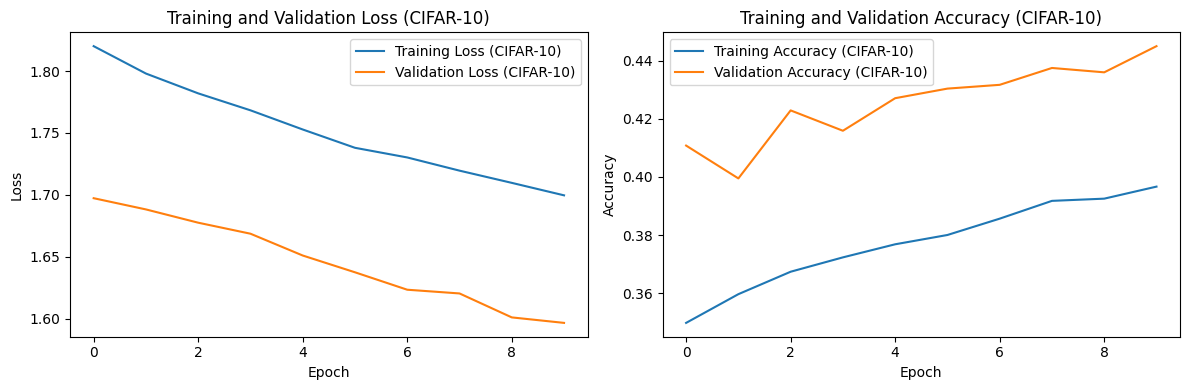

In [32]:
# Plot training loss and accuracy over epochs for CIFAR-10 dataset
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cifar.history["loss"], label="Training Loss (CIFAR-10)")
plt.plot(history_cifar.history["val_loss"], label="Validation Loss (CIFAR-10)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss (CIFAR-10)")

plt.subplot(1, 2, 2)
plt.plot(history_cifar.history["accuracy"], label="Training Accuracy (CIFAR-10)")
plt.plot(history_cifar.history["val_accuracy"], label="Validation Accuracy (CIFAR-10)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy (CIFAR-10)")

plt.tight_layout()
plt.show()